In [ ]:
# Install parameter optimization framework for later use
%%capture
!pip install optuna

In [ ]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random
import os
from PIL import Image, ImageFile
import torch
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
from collections import Counter
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm
import optuna
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/My\ Drive/airbus-ship-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_v2/f9775b70e.jpg  
  inflating: train_v2/f977a470c.jpg  
  inflating: train_v2/f9780bfaf.jpg  
  inflating: train_v2/f9782bdfe.jpg  
  inflating: train_v2/f9785ca49.jpg  
  inflating: train_v2/f9785e462.jpg  
  inflating: train_v2/f97a719d5.jpg  
  inflating: train_v2/f97afa376.jpg  
  inflating: train_v2/f97b85e3e.jpg  
  inflating: train_v2/f97bd0b11.jpg  
  inflating: train_v2/f97bd6b80.jpg  
  inflating: train_v2/f97bfb1b2.jpg  
  inflating: train_v2/f97c8cbbe.jpg  
  inflating: train_v2/f97cdd397.jpg  
  inflating: train_v2/f97d92e1e.jpg  
  inflating: train_v2/f97da9e70.jpg  
  inflating: train_v2/f97e843d3.jpg  
  inflating: train_v2/f97e961f2.jpg  
  inflating: train_v2/f97e96c68.jpg  
  inflating: train_v2/f97f63ae1.jpg  
  inflating: train_v2/f97f80839.jpg  
  inflating: train_v2/f97f83438.jpg  
  inflating: train_v2/f97fab9ad.jpg  
  inflating: train_v2/f97fd4915.jpg  
  inflating: train_v2/f9801bc03.jpg  

## 0. Data exploration

In [ ]:
# Explore dataset containing segmentation masks
df_masks = pd.read_csv('train_ship_segmentations_v2.csv')
df_masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [ ]:
# Add a column to indicate if an image has ships
df_masks['has_ship'] = df_masks['EncodedPixels'].notnull()

In [ ]:
# Dimension of images
image = plt.imread(f"train_v2/{df_masks['ImageId'].iloc[0]}")
width = image.shape[0]
height = image.shape[1]
print(f"Width: {width}, Height: {height}")

Width: 768, Height: 768


In [ ]:
# Count the number of images, the number with ships, and calculate the ratio
num_images_total = df_masks['ImageId'].nunique()
num_images_with_ships = df_masks[df_masks['EncodedPixels'].notna()]['ImageId'].nunique()
num_images_without_ships = num_images_total - num_images_with_ships
ratio_ship_no_ship = num_images_with_ships / num_images_without_ships if num_images_without_ships != 0 else float('inf')

print(f"Total number of images: {num_images_total}")
print(f"Number of images with ships: {num_images_with_ships}")
print(f"Number of images without ships: {num_images_without_ships}")
print(f"Ratio of images with ships to without ships: {ratio_ship_no_ship:.2f}")
df_masks.shape

Total number of images: 192556
Number of images with ships: 42556
Number of images without ships: 150000
Ratio of images with ships to without ships: 0.28


(231723, 3)

In [ ]:
def rle_decode(mask_rle, shape=(width, height)):
    """
    Decodes a run-length encoded (RLE) mask string into a 2D binary mask array.

    Run-Length Encoding (RLE) is a compact representation of binary masks.
    The mask is represented as pairs of start and length values, indicating the
    consecutive pixels that should be set to 1 (foreground) in an otherwise zero
    (background) mask.
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

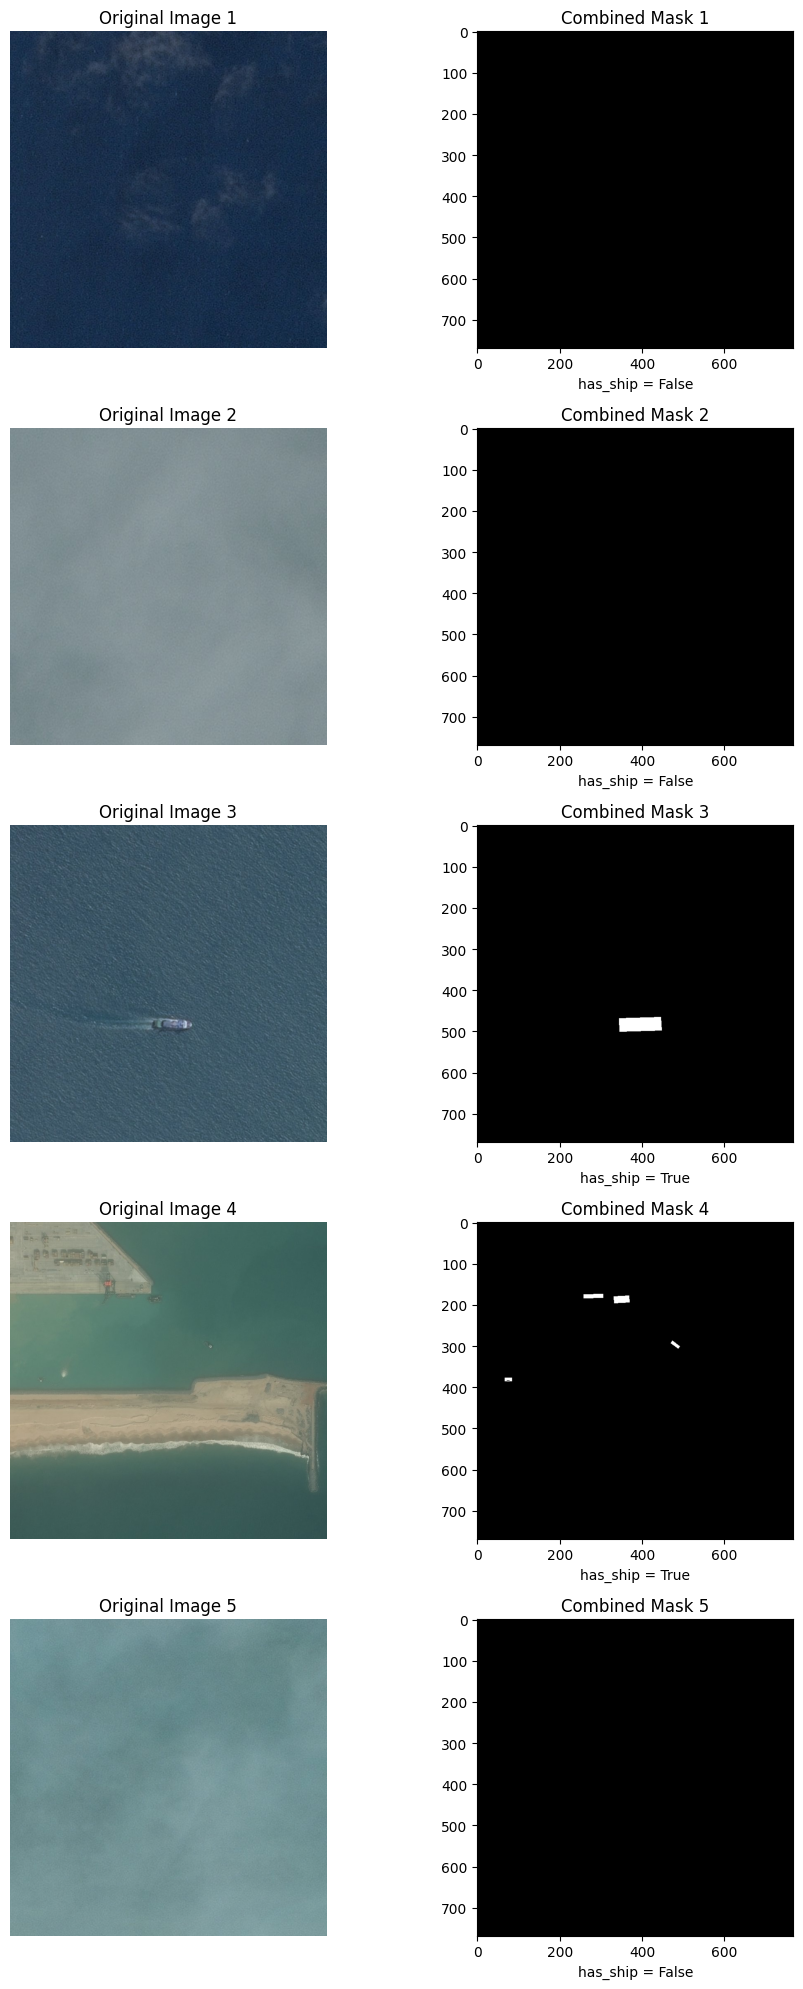

In [ ]:
num_images = 5
plt.figure(figsize=(10, 20))

# Get unique image IDs to display
unique_image_ids = df_masks['ImageId'].unique()[:num_images]

for i, image_id in enumerate(unique_image_ids):
    # Select all Run-Length Encoding (RLE) masks for the current image
    image_rles = df_masks[df_masks['ImageId'] == image_id]['EncodedPixels'].values
    has_ship = df_masks[df_masks['ImageId'] == image_id]['has_ship'].values[0]  # Check if it has a ship

    # Load the original image from the training dataset (train_v2 folder)
    image_path = f"train_v2/{image_id}"
    image = plt.imread(image_path)  # Load the original image

    # Initialize an empty mask
    combined_mask = np.zeros((width, height), dtype=np.uint8)

    # Decode each RLE and combine the masks
    for rle in image_rles:
        if pd.notna(rle):  # If RLE is not NaN, decode it
            combined_mask |= rle_decode(rle, shape=(width, height))  # Combine masks using logical OR

    # Display the original image
    plt.subplot(num_images, 2, 2 * i + 1)  # Two columns: original image on the left
    plt.imshow(image)  # Display the original image
    plt.title(f"Original Image {i + 1}")  # Title for the original image
    plt.axis('off')  # Remove axis for a cleaner display

    # Display the combined mask
    plt.subplot(num_images, 2, 2 * i + 2)  # Two columns: mask on the right
    plt.imshow(combined_mask, cmap='gray')  # Show the mask in grayscale
    plt.title(f"Combined Mask {i + 1}")  # Title for each mask
    plt.xlabel(f"has_ship = {has_ship}")  # Add text below indicating if the image has a ship

plt.tight_layout()
plt.show()

## 1. Creating training and validation datasets, prepare for training

In [ ]:
class ShipDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        self.image_ids = df['ImageId'].unique()

        print("Grouping ImageIds with their masks...")
        self.imageid_to_mask = df.groupby('ImageId')['EncodedPixels'].apply(list).to_dict()
        print("Grouping completed.")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, img_id)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Image {img_path} not found.")

        masks = self.imageid_to_mask[img_id]
        mask = np.zeros((768, 768), dtype=np.uint8)
        for m in masks:
            if isinstance(m, str):
                mask |= rle_decode(m, shape=(768, 768))

        mask = Image.fromarray(mask)

        if self.transforms:
            image, mask = self.transforms(image, mask)

        return image, mask

In [ ]:
def basic_transforms(image, mask):
    resize_size = (256, 256)
    image = image.resize(resize_size, resample=Image.BILINEAR)
    mask = mask.resize(resize_size, resample=Image.NEAREST)

    # Convert to tensors
    image = TF.to_tensor(image)
    mask = torch.from_numpy(np.array(mask)).unsqueeze(0).float()
    return image, mask

In [ ]:
img_dir = 'train_v2/'
dataset = ShipDataset(df_masks, img_dir=img_dir, transforms=basic_transforms)

Grouping ImageIds with their masks...
Grouping completed.


In [ ]:
imageid_to_has_ship = df_masks.groupby('ImageId')['has_ship'].any().to_dict()

# Calculate class counts
class_counts = Counter([imageid_to_has_ship[img_id] for img_id in dataset.image_ids])
print(f"Class counts in combined dataset: {class_counts}")

Class counts in combined dataset: Counter({False: 150000, True: 42556})


In [ ]:
# Since there is a huge imbalance between the images containing ships and the images containing no ships,
# we use weighted random sampling to upsample the ship-containing image dataset for each batch

In [ ]:
# Split into train and validation indices maintaining class distribution
with_ship_indices = [i for i, img_id in enumerate(dataset.image_ids) if imageid_to_has_ship[img_id]]
without_ship_indices = [i for i, img_id in enumerate(dataset.image_ids) if not imageid_to_has_ship[img_id]]

train_with_ship, val_with_ship = train_test_split(with_ship_indices, test_size=0.2, random_state=42)
train_without_ship, val_without_ship = train_test_split(without_ship_indices, test_size=0.2, random_state=42)

# Combine train and validation indices
train_indices = train_with_ship + train_without_ship
val_indices = val_with_ship + val_without_ship

# Shuffle the indices
random.shuffle(train_indices)
random.shuffle(val_indices)

In [ ]:
# Create Subsets
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")

Training samples: 154044
Validation samples: 38512


In [ ]:
# Create a list of image_ids for train and validation
train_image_ids = [dataset.image_ids[i] for i in train_indices]
val_image_ids = [dataset.image_ids[i] for i in val_indices]

In [ ]:
# Compute class weights
class_weights = {
    True: 1.0 / class_counts[True],
    False: 1.0 / class_counts[False]
}
print(f"Class weights: {class_weights}")

# Assign weights to training samples
train_weights = [class_weights[imageid_to_has_ship[img_id]] for img_id in train_image_ids]
train_weights = torch.tensor(train_weights, dtype=torch.double)

# Create WeightedRandomSampler for training
train_sampler = WeightedRandomSampler(
    weights=train_weights,
    num_samples=len(train_weights),
    replacement=True
)

Class weights: {True: 2.3498449102359245e-05, False: 6.666666666666667e-06}


In [ ]:
batch_size = 128
num_workers = 4

# Create DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No sampler for validation
    num_workers=num_workers
)

print(f"Training DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")

Training DataLoader has 1204 batches.
Validation DataLoader has 301 batches.


In [ ]:
# Helper function to display a random sample from a dataset
def display_random_sample(dataset):
    # Get a random index
    random_idx = random.randint(0, len(dataset) - 1)

    # Retrieve the image and mask
    image, mask = dataset[random_idx]

    # Convert tensors to NumPy arrays
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy()

    # Display
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(image_np)
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask_np, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()

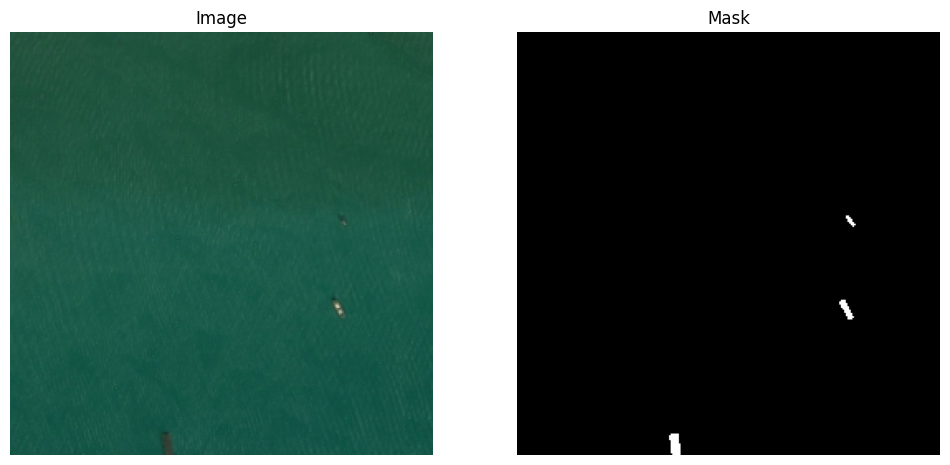

In [ ]:
display_random_sample(val_subset)

## 2. Loading DeeplabV3, training

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Calculate weights for each sample
class_counts = df_masks['has_ship'].value_counts()
class_weights = {
    True: 1.0 / class_counts[True],
    False: 1.0 / class_counts[False]
}

# Assign weight to each sample in the dataset
weights = [class_weights[imageid_to_has_ship[dataset.image_ids[i % len(dataset.image_ids)]]]
           for i in range(len(dataset))]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

Using device: cuda


In [ ]:
# Initialize DeepLabV3 with a ResNet-50 backbone
model = models.segmentation.deeplabv3_resnet50(pretrained=True)

# Modify the classifier to output 1 channel (binary segmentation)
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, 1)

# Move the model to the appropriate device
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 187MB/s]


In [ ]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Optionally, define a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def calculate_iou(preds, masks, threshold=0.5):
    """
    Calculates Intersection over Union (IoU) for binary segmentation.

    Args:
        preds (torch.Tensor): Predicted logits with shape (N, 1, H, W).
        masks (torch.Tensor): Ground truth masks with shape (N, 1, H, W).
        threshold (float): Threshold to convert logits to binary predictions.

    Returns:
        float: IoU score.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3)) - (preds * masks).sum(dim=(2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_iou = 0

    for images, masks in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        epoch_iou += calculate_iou(outputs, masks) * images.size(0)

    avg_loss = epoch_loss / len(loader.dataset)
    avg_iou = epoch_iou / len(loader.dataset)
    return avg_loss, avg_iou

def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_iou = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            epoch_loss += loss.item() * images.size(0)
            epoch_iou += calculate_iou(outputs, masks) * images.size(0)

    avg_loss = epoch_loss / len(loader.dataset)
    avg_iou = epoch_iou / len(loader.dataset)
    return avg_loss, avg_iou

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Training parameters
num_epochs = 5
best_val_iou = 0.0

# Early Stopping parameters
patience = 5  # Number of epochs to wait before stopping
epochs_no_improve = 0
early_stop = False

# Initialize lists to store metrics
train_losses = []
train_ious = []
val_losses = []
val_ious = []
epochs_list = []

for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered.")
        break

    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")

    # Validation phase
    val_loss, val_iou = validate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Check for improvement
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), "best_deeplabv3_model.pth")
        print("Saved Best Model")
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1
        print(f"No improvement in Val IoU for {epochs_no_improve} epoch(s)")

    # Append metrics to lists
    epochs_list.append(epoch + 1)
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    # Check if early stopping should be triggered
    if epochs_no_improve >= patience:
        print(f"Validation IoU did not improve for {patience} consecutive epochs.")
        print("Early stopping...")
        early_stop = True

    print("-" * 30)


Epoch 1/5


Train Loss: 0.0393, Train IoU: 0.6144


Val Loss: 0.0064, Val IoU: 0.8548
Saved Best Model
------------------------------
Epoch 2/5


Train Loss: 0.0048, Train IoU: 0.6998


Val Loss: 0.0023, Val IoU: 0.8724
Saved Best Model
------------------------------
Epoch 3/5


Train Loss: 0.0025, Train IoU: 0.7279


Val Loss: 0.0013, Val IoU: 0.8795
Saved Best Model
------------------------------
Epoch 4/5


Train Loss: 0.0017, Train IoU: 0.7479


Val Loss: 0.0011, Val IoU: 0.8843
Saved Best Model
------------------------------
Epoch 5/5


Train Loss: 0.0014, Train IoU: 0.7620


Val Loss: 0.0008, Val IoU: 0.8885
Saved Best Model
------------------------------


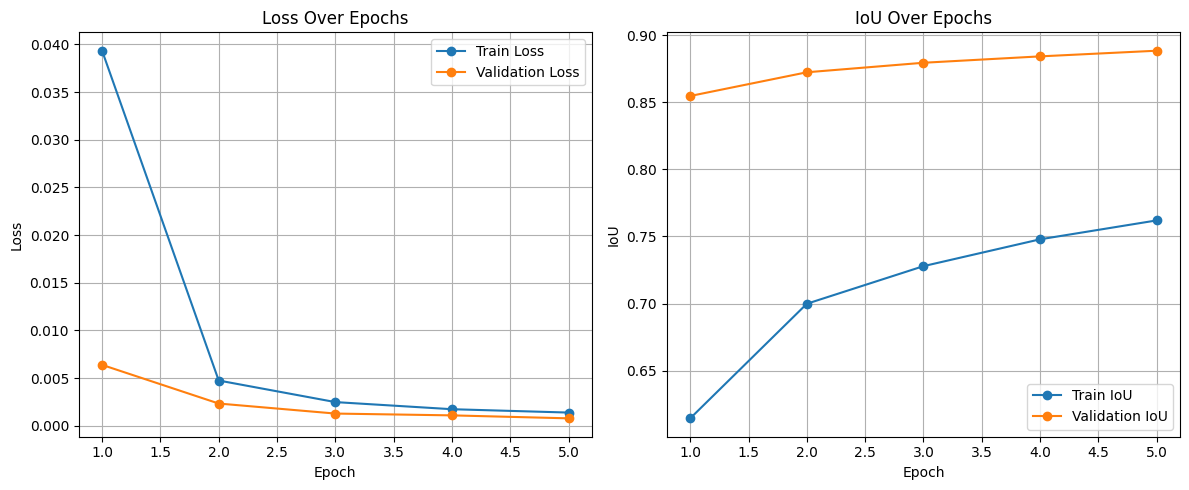

In [ ]:
 # Plot Loss and IoU after training
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_list, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_ious, label='Train IoU', marker='o')
plt.plot(epochs_list, val_ious, label='Validation IoU', marker='o')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model
model.load_state_dict(torch.load("best_deeplabv3_model.pth"))
model.eval()

<ipython-input-31-a1b36c62c475>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplabv3_model.pth"))


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

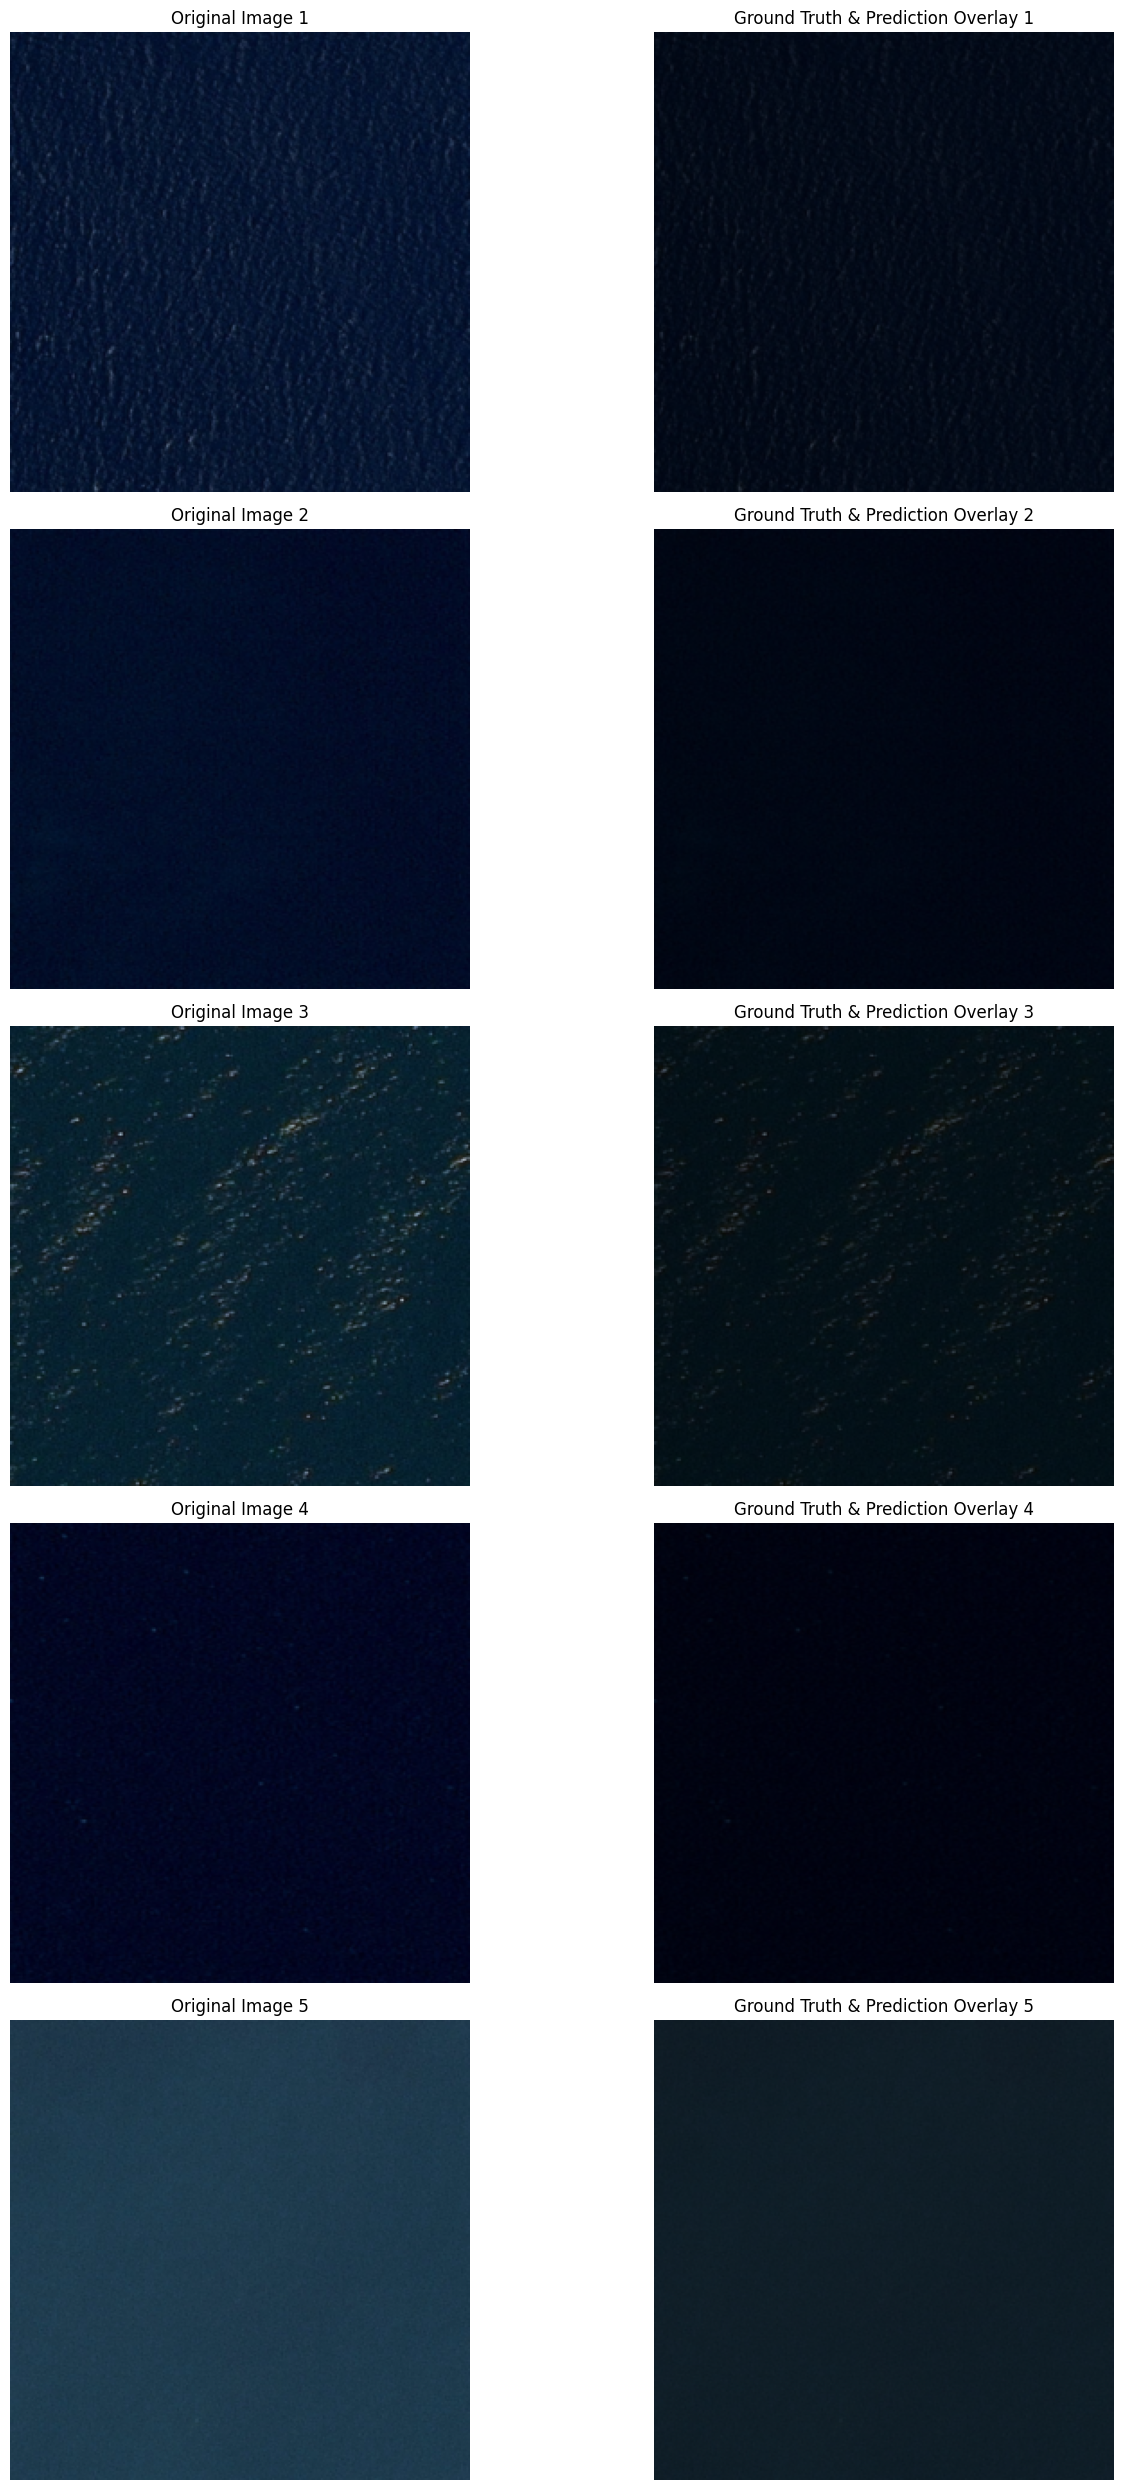

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=5, threshold=0.5):
    """
    Visualizes predictions by overlaying ground truth and predicted masks on the original image.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        dataset (torch.utils.data.Dataset): Dataset containing images and masks.
        device (torch.device): Device to perform computations on.
        num_samples (int): Number of samples to visualize.
        threshold (float): Threshold to binarize predicted masks.
    """
    model.eval()
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Get random image and their mask from dataset
        random_idx = random.randint(0, len(dataset) - 1)
        image, mask = dataset[random_idx]

        # Add batch dimension and move to device
        image_batch = image.unsqueeze(0).to(device)

        with torch.no_grad():
            # Get model prediction
            output = model(image_batch)['out']
            pred = torch.sigmoid(output).squeeze().cpu().numpy()
            pred = (pred > threshold).astype(np.uint8)

        # Convert tensors to numpy arrays for plotting
        image_np = image.cpu().numpy().transpose(1, 2, 0)
        mask_np = mask.cpu().numpy().squeeze()

        # Ensure the image is in [0,1] range
        image_np = np.clip(image_np, 0, 1)

        # Create a color overlay
        overlay = np.zeros_like(image_np)

        # Define colors: Ground Truth - Green, Prediction - Red
        # Overlap will appear as Yellow (Red + Green)
        overlay[mask_np == 1] = [0, 1, 0]  # Green for ground truth
        overlay[pred == 1] += [1, 0, 0]    # Red for prediction

        # To prevent values from exceeding 1
        overlay = np.clip(overlay, 0, 1)

        # Blend the original image with the overlay
        alpha = 0.5  # Transparency factor
        blended = image_np * (1 - alpha) + overlay * alpha

        # Plot Original Image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image_np)
        plt.title(f"Original Image {i + 1}")
        plt.axis('off')

        # Plot Blended Image with Overlays
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(blended)
        plt.title(f"Ground Truth & Prediction Overlay {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize some predictions
visualize_predictions(model, val_subset, device, num_samples=5)

## 3. Hyperparameter optimization

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    criterion = nn.BCEWithLogitsLoss()

    # Choose optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Scheduler (if needed)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Early stopping parameters
    patience = 3
    epochs_no_improve = 0
    best_val_iou = 0.0

    # For demonstration, let's run fewer epochs during hyperparameter search
    NUM_BASE_EPOCHS = 3

    for epoch in range(NUM_BASE_EPOCHS):
        train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_iou = validate(model, val_loader, criterion, device)

        # Step the scheduler
        scheduler.step(val_loss)

        # Check improvement
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Report intermediate results to Optuna
        trial.report(val_iou, epoch)

        # Check for trial pruning (early stopping)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Optional early stopping outside of pruning if you want
        if epochs_no_improve >= patience:
            break

    return best_val_iou


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

# Print the best hyperparameters
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-12-08 16:40:03,515] A new study created in memory with name: no-name-dfd17771-d99a-4ada-ac9f-d8445cc5209a
<ipython-input-33-381b3d9aba29>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2024-12-08 17:26:33,091] Trial 0 finished with value: 0.8386986338601946 and parameters: {'lr': 0.008040355405876623}. Best is trial 0 with value: 0.8386986338601946.
[W 2024-12-08 17:26:40,190] Trial 1 failed with parameters: {'lr': 0.001215008212107922} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-33-381b3d9aba29>", line 22, in objective
    train_loss, train_iou = train_one_epoch(model, 

KeyboardInterrupt: 

<a target="_blank" href="https://colab.research.google.com/github/istex9/ctr-alt-segmentAnything/blob/main/airbus_ship_detection.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>